# MCS Integration

Please check that you are in the correct Python virtual environment:

In [1]:
println(ENV["PYTHON"])

/home/falk/.julia/dev/GLRenderer.jl/venv/bin/python


Standard imports.

In [3]:
import Revise
import GLRenderer
import PoseComposition
import Rotations
import Geometry
import Plots
import Images

import Gen
import Distributions

import GenParticleFilters
PF = GenParticleFilters

I = Images
PL = Plots

R = Rotations
P = PoseComposition
GL = GLRenderer
# -

Revise.errors()
Revise.revise()

┌ Info: Precompiling GLRenderer [d1e26eb4-c061-4a47-b8d4-4152ce573b03]
└ @ Base loading.jl:1317


Start MCS. Please make sure you set the environment variables `MCS_CONFIG_FILE_PATH`, `MCS_EXECUTABLE_PATH`, `PRAM_MODE` and `PRAM_PATH` as described [here](https://github.com/probcomp/GenPRAM.jl#environment-variables), i.e.

- `PRAM_PATH` Path to GenPRAM repository, ideally cloned to ~/.julia/dev
- `MCS_CONFIG_FILE_PATH` Path to MCS config file
- `MCS_EXECUTABLE_PATH` Path to MCS executable (data directory is assumed to be in same folder)
- `PRAM_MODE` Mode of running PRAM - currently "debug" (sends to Redis), "batch" (runs in bulk, sends results to server) or "submission" (no services, just execute)

In [7]:
import PyPlot
plt = PyPlot.plt

using PyCall
@pyimport machine_common_sense as mcs
StepMetadata=mcs.StepMetadata
ObjectMetadata=mcs.ObjectMetadata

global numpy = pyimport("numpy")
@pyimport numpy as np

# +
using Serialization
using StaticArrays
import GenGridSLAM: astar_search, backproject_grid_coord_to_world_coord, CameraIntrinsics, ccl, centroid_direction, centroid_direction_2, cloud_from_step_metadata,
    cloud_to_grid_coords, compute_frontier,
    convert_probabilistic_occupancy_grid_to_string_array, count_component_size,
    create_2d_occupancy_grid_with_segment_ids, expand_2d_occupancy_grid_dict_into_full_matrix, find_closest_unexplored_component,
    find_max_component, flip_array, generate_pddl, get_agent_grid_position_and_rotation, grid_coords_to_cloud, grid_xz_to_map_xz,
    in_grid_bounds, map_xz_to_grid_xz,
    OccupancyGrid, OccupancyGridConfig, pretty_print_occupancy_grid, pretty_print_occupancy_grid_string_array,
    print_occupancy_grid, project_3d_occupancy_grid_into_2d_dict, render_occupancy_grid, render_occupancy_grid_oriented,
    set_entry!, update_occupancy_grid!, project_3d_og_to_2d, generate_maps_2d_oriented, world_point_to_oriented_grid_coordinates

pram_path = ENV["PRAM_PATH"]
include("$(pram_path)/GenAgent/src/config/config.jl")
include("$(pram_path)/GenAgent/src/state/agent.jl")
include("$(pram_path)/GenAgent/src/submission.jl")

scene_path=joinpath(pwd(), "data/rectangular_colored_walls_empty.json")
mcs_executable_path=ENV["MCS_EXECUTABLE_PATH"]
mcs_config_path=ENV["MCS_CONFIG_FILE_PATH"]

config_data, status = mcs.load_scene_json_file(scene_path)
controller = mcs.create_controller(unity_app_file_path=mcs_executable_path,
                                   config_file_path=mcs_config_path)
step_metadata = controller.start_scene(config_data)

config = McsConfiguration()
information_level = infer_information_level(step_metadata)

intrinsics = CameraIntrinsics(step_metadata)
agent = Agent(intrinsics, [step_metadata], [],
              [Pose([0.0,0.0,0.0],  0.0, step_metadata.head_tilt)],
              [], nothing, information_level, config)

# Overwrite pram_mode so we don't need to deal with Redis etc.
ENV["PRAM_MODE"] = "submission"
agent.config.compute_configuration.pram_mode = ENV["PRAM_MODE"]

# Load target model
trophy_model_path = joinpath(config.path_configuration.pram_path, "GenAgent/omg/models/soccer_ball.model")
println("Loading trophy model from $(trophy_model_path).")
trophy_model = deserialize(trophy_model_path)

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1317
┌ Info: Precompiling GenGridSLAM [f2c34361-00aa-41b4-8eea-3fb40af399b2]
└ @ Base loading.jl:1317
┌ Info: Precompiling Perception [bb87f8c5-f65d-460d-aee3-50fa78b9c6e7]
└ @ Base loading.jl:1317


Found path: /home/falk/mitibm/AI2Thor_MCS/MCS-AI2-THOR-Unity-App-v0.4.3.x86_64


Loading trophy model from /home/falk/.julia/dev/GenPRAM.jl/GenAgent/omg/models/soccer_ball.model.


6×3075 Matrix{Float64}:
   0.107819     0.104997    0.103968   …  -0.104063   -0.104063   -0.104063
   0.118939     0.132016    0.134342       0.102431    0.0948061   0.0833685
   0.0196079    0.0         0.0196079     -0.0361266  -0.0361266  -0.0361266
 139.0        143.0       134.0           93.0        15.0        24.0
 146.0        150.0       140.0           98.0        18.0        29.0
 143.0        146.0       137.0        …  95.0        16.0        26.0

In [9]:
function find_scanline(valid_index_mask)
    valid_rows = prod(valid_index_mask, dims=2)  # (400, 1) vector - pick index with value 1
    for row_idx in 1:size(valid_rows)[1]
        if valid_rows[row_idx]
            return row_idx
        end
    end
    return -1
end

"""
Same as `get_scanline()`, but works on camera frame point cloud
without depending on global coordinates. Based on `detect_corner_from_camera_frame(agent)`.
"""
function get_scanline_from_camera_frame(agent::Agent; verbose = false)
    
    step_metadata = agent.step_metadatas[end]
    
    cloud = cloud_from_depth_map(
                Matrix(numpy.array(last(step_metadata.depth_map_list))),
                intrinsics.cx, intrinsics.cy,
                intrinsics.fx, intrinsics.fy,
                intrinsics.width, intrinsics.height; stride_x=1, stride_y=1
            )
    cloud_array_2d = reshape(cloud, (3, size(agent.step_metadatas[end].depth_map_list[end])...))
    
    # We could get point cloud in world frame like this, but don't know our pose after kidnapping:
    # pose = agent.poses[end]
    # cloud = rotate_cloud(cloud; head_tilt_deg=pose.head_tilt, view_angle_deg=pose.rotation)
    # cloud = translate_cloud(cloud, pose.position)
    # cloud_array_2d_b = reshape(cloud, (3, size(agent.step_metadatas[end].depth_map_list[end])...));
    
    height_offset = 0.1
    min_height, max_height = minimum(cloud[2, :]) + height_offset, maximum(cloud[2, :]) - height_offset
    if verbose println("Height range: $(min_height) to $(max_height)") end

    # Boolean mask for all pixels that are definitely not ceiling or floor
    valid_indices = (cloud[2,:] .> min_height) .& (cloud[2,:] .< max_height)
    valid_indices_2d = reshape(valid_indices, size(agent.step_metadatas[end].depth_map_list[end]))

    scanline_idx = find_scanline(valid_indices_2d)
    
    return cloud_array_2d, scanline_idx
end

rows_of_interest_local = []

for _ in 1:36
    execute_command(controller, agent, "RotateRight")
    cloud_array_2d, scanline_idx = get_scanline_from_camera_frame(agent)
    roi = cloud_array_2d[1:3, scanline_idx, :]
    if !isnothing(roi) push!(rows_of_interest_local, roi) end
end

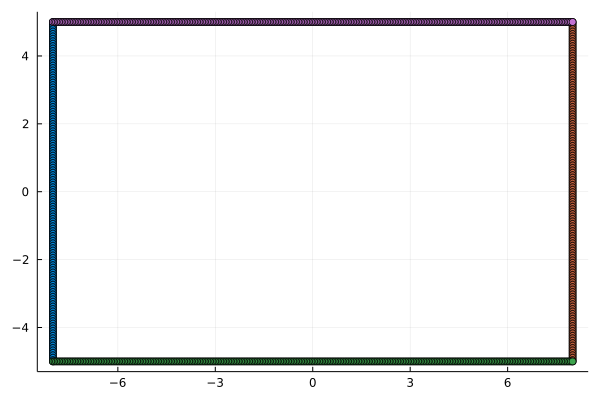

In [10]:
room_height_bounds = (-5.0, 5.0)
room_width_bounds = (-8.0, 8.0)

resolution = 0.1
room_cloud_1 = []
room_cloud_2 = []
room_cloud_3 = []
room_cloud_4 = []

for z in room_height_bounds[1]:resolution/2.0:room_height_bounds[2]
    push!(room_cloud_1, [room_width_bounds[1], 0.0, z])
    push!(room_cloud_2, [room_width_bounds[2], 0.0, z])
end
for x in room_width_bounds[1]:resolution/2.0:room_width_bounds[2]
    push!(room_cloud_3, [x, 0.0, room_height_bounds[1]])
    push!(room_cloud_4, [x, 0.0, room_height_bounds[2]])
end


room_cloud_1 = hcat(room_cloud_1...)
room_cloud_2 = hcat(room_cloud_2...)
room_cloud_3 = hcat(room_cloud_3...)
room_cloud_4 = hcat(room_cloud_4...)

v1,n1,f1 = GL.mesh_from_voxelized_cloud(GL.voxelize(room_cloud_1, resolution), resolution * 1.05)
v2,n2,f2 = GL.mesh_from_voxelized_cloud(GL.voxelize(room_cloud_2, resolution), resolution * 1.05)
v3,n3,f3 = GL.mesh_from_voxelized_cloud(GL.voxelize(room_cloud_3, resolution), resolution * 1.05)
v4,n4,f4 = GL.mesh_from_voxelized_cloud(GL.voxelize(room_cloud_4, resolution), resolution * 1.05)

room_cloud = hcat(room_cloud_1, room_cloud_2, room_cloud_3, room_cloud_4)

PL.scatter(room_cloud_1[1,:], room_cloud_1[3,:],label="")
PL.scatter!(room_cloud_2[1,:], room_cloud_2[3,:],label="")
PL.scatter!(room_cloud_3[1,:], room_cloud_3[3,:],label="")
PL.scatter!(room_cloud_4[1,:], room_cloud_4[3,:],label="")

# PL.scatter!(v2[:,1],v2[:,3],label="")
# PL.scatter!(v3[:,1],v3[:,3],label="")
# PL.scatter!(v4[:,1],v4[:,3],label="")
# -

# Subsampling Camera Intrinsics Transfomation

The code below shows how we take a `camera_intrinsics_1` and scale it down by a factor of `FACTOR` to get new intrinsics parameters `camera_intrinsics_2`. When we render out depth images from both of these cameras, we see that the depth image from `camera_intrinsics_2` is just a subsampled version of the depth image from `camera_intrinsics_1`.

Size of `depth_1` is `(1, 320)`, whereas size of `depth_2` is `(1, 80)`.

## Questions
- 600 (MCS width; height is 400) is not divisble by 14 (target width for generative model; would yield ~42.857). Closest `FACTOR` should be `40`. Hence, I fear an `InexactError` if we need to use a floating point factor. How to resolve this?
- MCS intrinsics should be `CameraIntrinsics(600, 400, 1.0561261617822306, 0.7417649320975901, 514.2991467983065, 514.2991467983065, 300.0, 200.0, 1.5, 25.0, 0.1)` or so. Do we care that this does not seem to match the intrinsics below? Not sure which value the FoV is, but they seem to differ.
- We now have `Geometry.CameraIntrinsics`, `GenGridSLAM.CameraIntrinsics` and `Perception.CameraIntrinsics` - it seems like we need to consolidate this, since it makes things confusing.

In [21]:
W = 600
camera_intrinsics_1 = Geometry.CameraIntrinsics(
    W, 1,
    20.0, 1.0,
    W/2.0, 0.5,
    0.1, 20.0
)
renderer = GL.setup_renderer(camera_intrinsics_1, GL.DepthMode())
GL.load_object!(renderer, v1, f1)
GL.load_object!(renderer, v2, f2)
GL.load_object!(renderer, v3, f3)
GL.load_object!(renderer, v4, f4)
renderer.gl_instance.lightpos = [0, 0, 0]

cam_pose = P.Pose([1.0, 0.0, 3.0], R.RotY(-pi/4+ 0.0))
wall_colors = [I.colorant"red", I.colorant"green", I.colorant"blue", I.colorant"yellow"]
# wall_colors = [I.colorant"red",I.colorant"red",I.colorant"red",I.colorant"red"]
@time depth_1 = GL.gl_render(
    renderer, 
    [1,2,3,4], [P.IDENTITY_POSE, P.IDENTITY_POSE, P.IDENTITY_POSE, P.IDENTITY_POSE],
    cam_pose
);

FACTOR = 40
DESIRED_WIDTH = W / FACTOR

camera_intrinsics_2 = Geometry.CameraIntrinsics(
    DESIRED_WIDTH, 1,
    camera_intrinsics_1.fx / FACTOR, 1.0,
    DESIRED_WIDTH / 2.0 .+ (1/2 - 1/FACTOR *1/2) , 0.5,
    0.1, 20.0
)
renderer = GL.setup_renderer(camera_intrinsics_2, GL.DepthMode())
GL.load_object!(renderer, v1, f1)
GL.load_object!(renderer, v2, f2)
GL.load_object!(renderer, v3, f3)
GL.load_object!(renderer, v4, f4)
renderer.gl_instance.lightpos = [0,0,0]

wall_colors = [I.colorant"red", I.colorant"green", I.colorant"blue", I.colorant"yellow"]
# wall_colors = [I.colorant"red",I.colorant"red",I.colorant"red",I.colorant"red"]
@time depth_2 = GL.gl_render(
    renderer, 
    [1,2,3,4], [P.IDENTITY_POSE, P.IDENTITY_POSE,P.IDENTITY_POSE,P.IDENTITY_POSE],
    cam_pose
);

camera_intrinsics_2

  0.001252 seconds (143 allocations: 14.375 KiB)


libEGL warning: DRI2: failed to create dri screen
libEGL warning: DRI2: failed to create dri screen
Unable to initialize EGL
libEGL warning: DRI2: failed to create dri screen
libEGL warning: DRI2: failed to create dri screen
Unable to initialize EGL


  0.001271 seconds (141 allocations: 7.375 KiB)
number of devices found 5
Loaded EGL 1.5 after reload.
number of devices found 5
Loaded EGL 1.5 after reload.


libEGL warning: DRI2: failed to create dri screen
libEGL warning: DRI2: failed to create dri screen
Unable to initialize EGL
libEGL warning: DRI2: failed to create dri screen
libEGL warning: DRI2: failed to create dri screen
Unable to initialize EGL


Geometry.CameraIntrinsics
  width: Int64 15
  height: Int64 1
  fx: Float64 0.5
  fy: Float64 1.0
  cx: Float64 7.9875
  cy: Float64 0.5
  near: Float64 0.1
  far: Float64 20.0


In [32]:
"""
Converts to intrinsics for slice of height 1
"""
function convert_camera_intrinsics(ci::Geometry.CameraIntrinsics, factor::Int)
    desired_width = ci.width / factor
    return Geometry.CameraIntrinsics(
    desired_width, 1,  # ci.height,
    ci.fx / factor, ci.fy,
    desired_width / 2.0 .+ (1/2 - 1/factor * 1/2) , 0.5,  # ci.cy,
    ci.near, ci.far
)
end

# Unit Test
ci_new = convert_camera_intrinsics(camera_intrinsics_1, 40)
camera_intrinsics_2 == ci_new

true

In [33]:
# (600, 400, 1.0561261617822306, 0.7417649320975901, 514.2991467983065, 514.2991467983065, 300.0, 200.0, 1.5, 25.0, 0.1)

camera_intrinsics_mcs = Geometry.CameraIntrinsics(
    600, 400,
    514.2991467983065, 514.2991467983065,
    300.0, 200.0,
    0.1, 25.0
)
convert_camera_intrinsics(camera_intrinsics_mcs, 40)

Geometry.CameraIntrinsics
  width: Int64 15
  height: Int64 1
  fx: Float64 12.857478669957663
  fy: Float64 514.2991467983065
  cx: Float64 7.9875
  cy: Float64 0.5
  near: Float64 0.1
  far: Float64 25.0


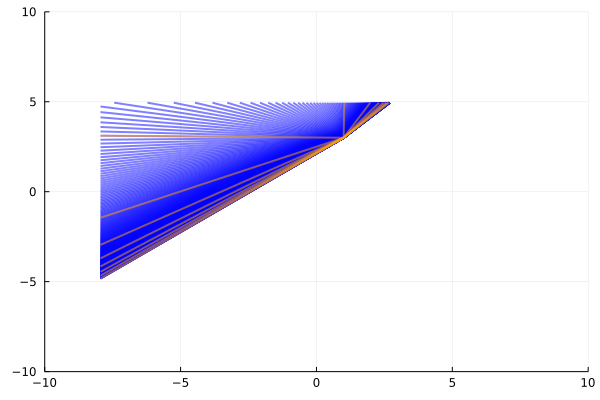

In [23]:
PL.plot()

cloud_1 = GL.flatten_point_cloud(GL.depth_image_to_point_cloud(depth_1, camera_intrinsics_1))
cloud_1 = GL.move_points_to_frame_b(cloud_1, cam_pose)

cloud_2 = GL.flatten_point_cloud(GL.depth_image_to_point_cloud(depth_2, camera_intrinsics_2))
cloud_2 = GL.move_points_to_frame_b(cloud_2, cam_pose)


pose = cam_pose
for i in 1:size(cloud_1)[2]
   PL.plot!([pose.pos[1], cloud_1[1,i]], [pose.pos[3], cloud_1[3,i]],
            color=I.colorant"blue",
            alpha=0.5,
            linewidth=2,
            label=false) 
end

for i in 1:size(cloud_2)[2]
   PL.plot!([pose.pos[1], cloud_2[1,i]], [pose.pos[3], cloud_2[3,i]],
            color=I.colorant"orange",
            alpha=0.5,
            linewidth=2,
            label=false) 
end


PL.plot!(xlim=(-10,10),ylim=(-10,10))

In [16]:
depth_1

depth_2

1×80 Matrix{Float64}:
 1.4099  1.44203  1.4756  1.51087  1.54789  …  0.326904  0.319325  0.312089

# Validation
Below, I validate that depth_2 is a subsmapled version of depth_1. @Falk, this means that to pass the depth "slices" from MCS as input to this system, you will have to first choose a `FACTOR` to resize by and then ensure you use the correct transformed camera model for the renderer using in our SLAM code. (Refer to the code above to see how we get `camera_intrinsics_2` from `camera_intrinsics_1`. This is the correct transformation.)

In [14]:
all(abs.(depth_1[1:FACTOR:end] .- depth_2[:]) .< 0.005)

true